# Выбор локации для скважины

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Обычные шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Оглавление
* 1 Загрузка и подготовка данных
* 2 Обучение и проверка моделей для каждого региона

* 3 Расчёт прибыли по выбранным скважинам и предсказаниям модели

* 4 Расчет рисков и прибыли для каждого региона:

## Загрузка и подготовка данных

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import phik
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
df = [pd.read_csv(f'/datasets/geo_data_{i}.csv') for i in range(3)]

In [4]:
df[0].head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


* id — уникальный идентификатор скважины
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы)
* product — объём запасов в скважине (тыс. баррелей)

In [5]:
for x in df:
    print(x.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

Данные верного формата, без пропусков. Выборка приличная - 100 000 точек

In [6]:
for x in df:
    print(x.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Дубликатов не обнаружено

/tmp/ipykernel_345/4252917842.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,2,j+1)


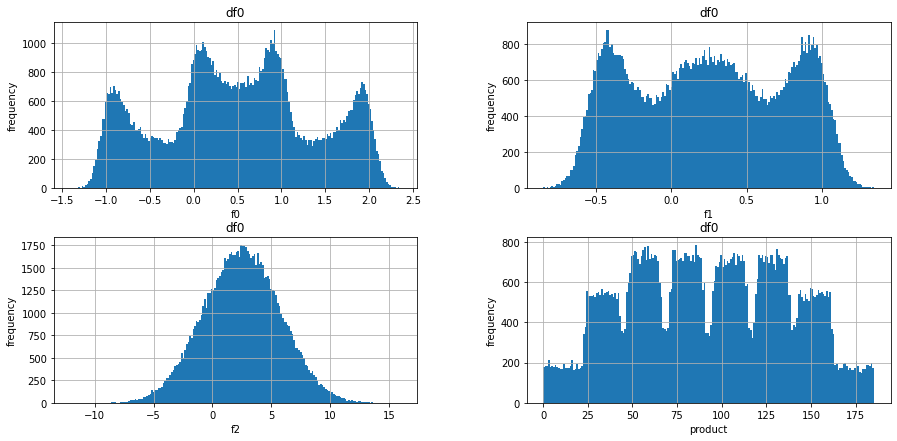

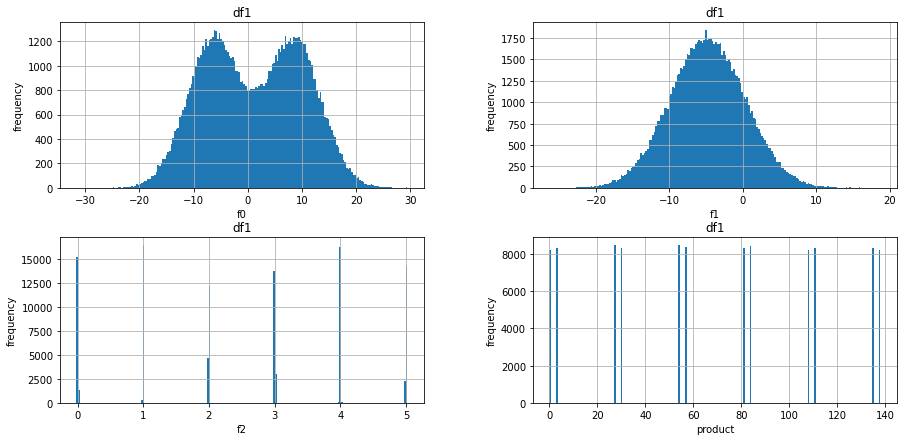

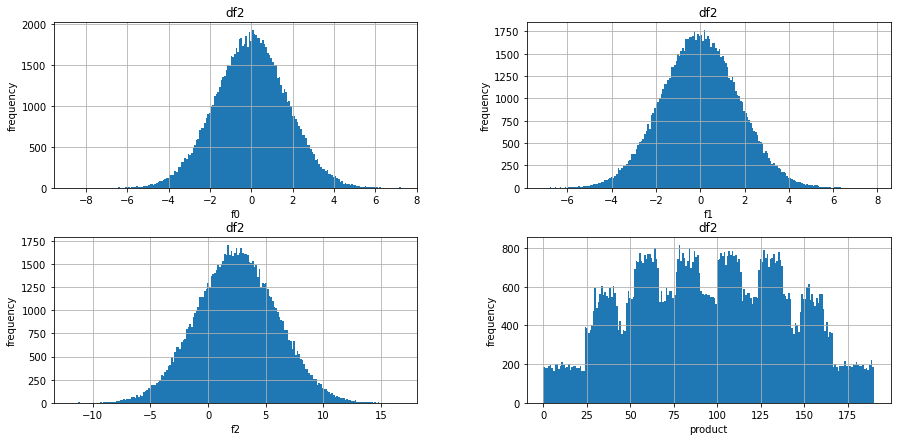

In [7]:
xlabel = df[0].drop(columns='id').columns
for i, x in enumerate(df):
    x.hist(figsize=(15,7), bins=200);
    for j in range(4):
        plt.subplot(2,2,j+1)
        plt.title(f'df{i}')
        plt.xlabel(xlabel[j])
        plt.ylabel('frequency')
    plt.show()

Данные весьма разношерстные - если для 0 и 2 месторождений признаки представляют собой единственный или композицию гауссовых пиков, то для 1 признаки f2 и product больше напоминают дискретные значения.

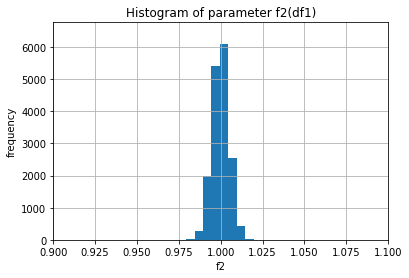

In [8]:
df[1]['f2'].hist(bins=1000)
plt.xlim(0.9, 1.1)
plt.xlabel('f2')
plt.ylabel('frequency')
plt.title('Histogram of parameter f2(df1)');
plt.show();

In [9]:
df[1]['product'].unique()

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

При ближайшем рассмотрении f2 оказалось композицией гауссовых пиков с малой дисперсией, product же действительно оказался дискретной величиной

df0


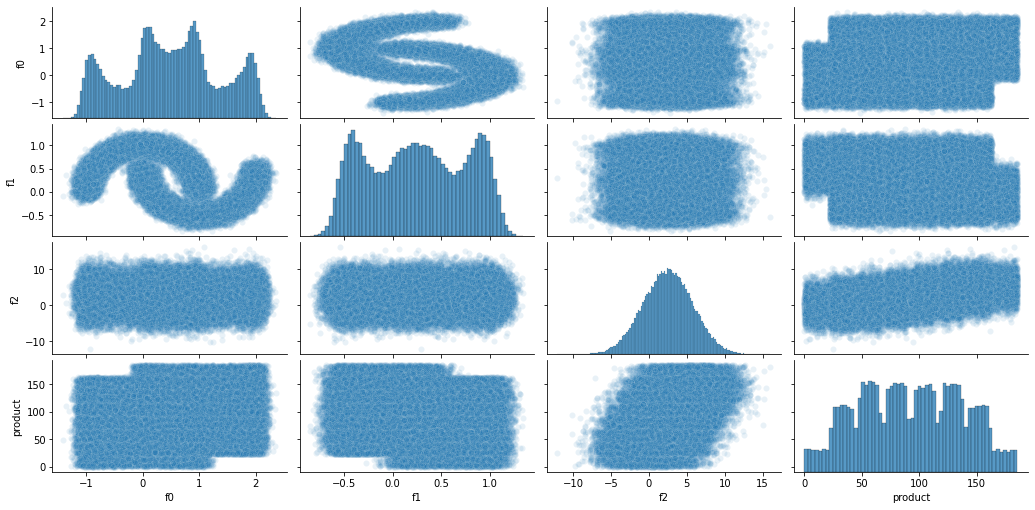

df1


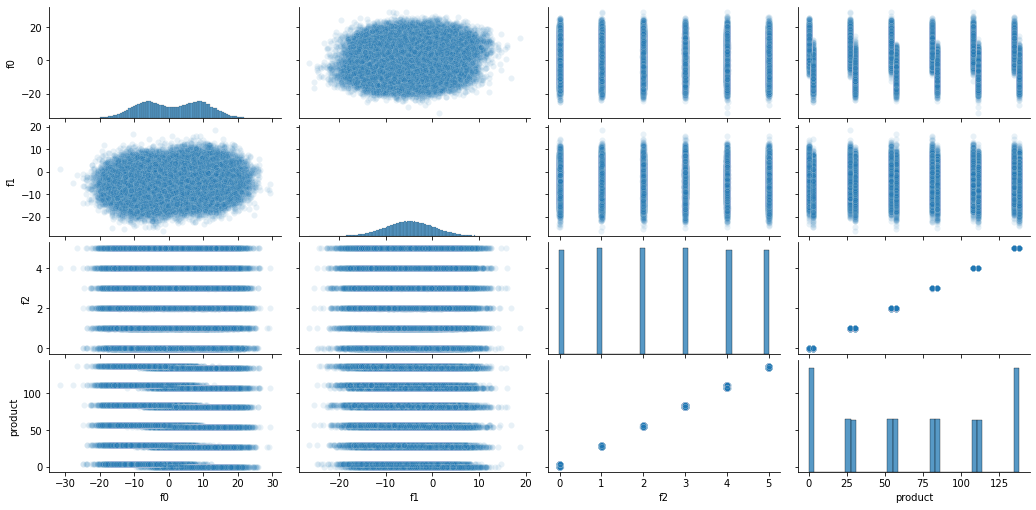

df2


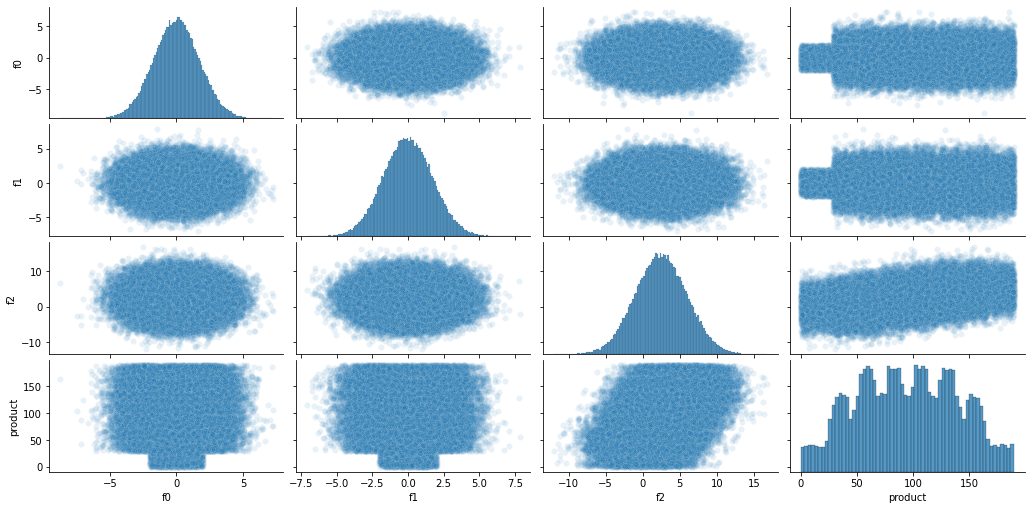

In [10]:
for i, x in enumerate(df):
    print(f'df{i}')
    sns.pairplot(x.drop(columns=['id']), plot_kws={'alpha':0.1})
    plt.gcf().set_size_inches(15,7);
    plt.show()

Отчетливо видны кластерные структуры, в дальнейшем можно будет их разделить для более точного предсказания.

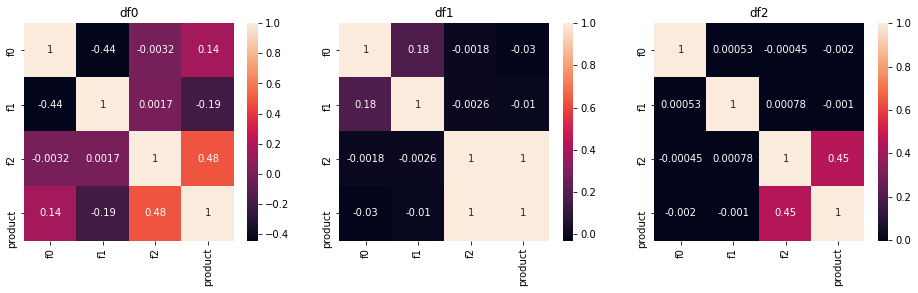

In [11]:
for i, x in enumerate(df):
    plt.subplot(1,3,i+1)
    sns.heatmap(x.corr(), annot=True)
    plt.title(f'df{i}')
plt.gcf().set_size_inches(16,4);

Исходя из матриц корреляции по коэффициенту Пирсона можно заключить о линейной независимости признаков f0 и f1 с целевым признаком в df1 и df2, из чего следует что в линейной модели эти признаки не будут существенным образом влиять на точность предсказания.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


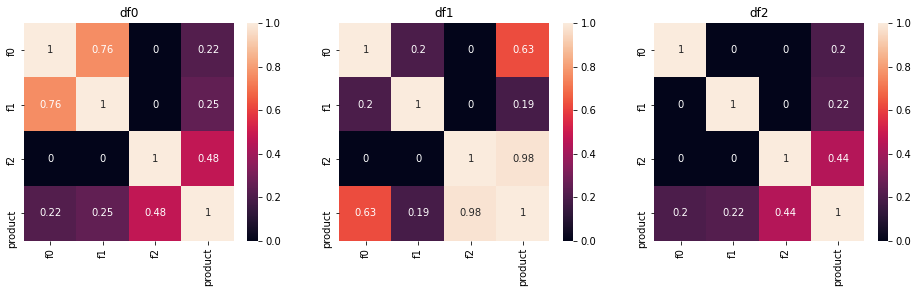

In [12]:
for i, x in enumerate(df):
    plt.subplot(1,3,i+1)
    sns.heatmap(x.drop(columns=['id']).phik_matrix(), annot=True)
    plt.title(f'df{i}')
plt.gcf().set_size_inches(16,4);

По матрице корреляции по коэффициенту Фика можно заключить, что эти же признаки имеют более высокий ранг зависимости. Возможно линейная модель - не лучший выбор для данной задачи. Чтобы решить задачу методом линейной регрессии - удалим признаки с малой корреляцией

In [13]:
df[1].drop(columns=['f0', 'f1'], inplace=True)
df[2].drop(columns=['f0', 'f1'], inplace=True)

**Данные не требуют значительной подготовки. Замечены кластерные структуры. Удалены линейно незначимые признаки**

## Обучение и проверка модели

По условию задачи пользоваться можно только простой линейной регрессией. Выполним фит по всем регионам по отдельности, предварительно стандартизировав признаки. Ориентироваться на качество модели будем по rmse и r2

In [14]:
scores = pd.DataFrame(index=['r2_train', 'r2_test', 'rmse_train', 'rmse_test', 'pred_mean'])
model_preds_and_answers = []

for i, x in enumerate(df):
    X_train, x_test, y_train, y_test = train_test_split(x.drop(columns=['id', 'product']), x['product'], 
                                                    test_size=0.25, random_state=42)
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    x_test = scaler.transform(x_test)

    model = LinearRegression()
    
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(x_test)
    
    scores[f'df{i}'] = [r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test),
                        mean_squared_error(y_train, y_pred_train)**0.5, mean_squared_error(y_test, y_pred_test)**0.5,
                        y_pred_test.mean()]

    model_preds_and_answers.append(pd.DataFrame({'predictions': y_pred_test, 'answers': y_test}))
    
scores.T

,r2_train,r2_test,rmse_train,rmse_test,pred_mean
df0,0.276653,0.272829,37.670499,37.756600,92.398800
df1,0.998794,0.998795,1.595380,1.595175,68.721217
df2,0.199602,0.196371,40.025456,40.145281,94.771131


Для df2 разброс получается наименьшим, что позволяет точно целевой признак. Для df 0 и 2 разброс много больше, однако и среднее тоже больше. Возможно на этих регионах тоже можно выгодно добывать, но более рискованно

## Подготовка к расчёту прибыли

Оценим какой в среднем объем необходим для окупаемости бурения 

* `budget` - общий бюджет выделенный на разработку в рублях
* `num_of_spots` - число разрабатываемых скважин
* `num_of_potencial_spots` - число потенциальных скважин, из которых выбирают какие разрабатывать
* `unit_price` - цена единицы объемаа (тыс. баррелей) в рублях
* `average_deposit_volume` - средний объем продукта в скважине по региону
* `spots_capacity` - средний объем необходимый для окупаемости скважины 

*Cредний объем необходимый для окупаемости скважины рассчитывается по формуле:*

$$\text{spots_capacity} = \frac{\text{budget}}{\text{num_of_spots} \cdot \text{unit_price}}$$

In [15]:
budget = 10 ** 10
num_of_spots = 200
num_of_potencial_spots = 500
unit_price = 450000
average_deposit_volume = [x['product'].mean() for x in df]

In [16]:
spots_capacity = budget / (num_of_spots * unit_price)
print(f'Объем в скважине для 0 выгоды (тыс. баррелей): {spots_capacity:4.1f}')

Объем в скважине для 0 выгоды (тыс. баррелей): 111.1


In [17]:
print(f'Средний объем по регионам: {average_deposit_volume[0]:4.1f}, {average_deposit_volume[1]:4.1f}, {average_deposit_volume[2]:4.1f}')

Средний объем по регионам: 92.5, 68.8, 95.0


Средние объемы во всех регионах по скважинам меньше среднего объема для скважины необходимого для окупаемости - бурить наугад не получится, необходимо выбирать по признакам наиболее перспективные места

In [18]:
def revenue(preds_and_answers, num_of_spots=num_of_spots):  
    '''фунция выбора наилучших объектов чилса num_of_spots и  подсчет возможной прибыли'''
    preds_and_answers_sorted = preds_and_answers.sort_values(by='predictions', ascending=False)
    selected = preds_and_answers_sorted['answers'][:num_of_spots] 
    return unit_price * selected.sum()

## Расчёт прибыли и рисков 

Оценим средний оборот, его 95% интервал и вероятность убытков для каждого региона, если бурение будет производиться на 200 из 500 наилучших скважинах по предсказанному показателю.

In [19]:
state = np.random.RandomState(42)
profit_scores = pd.DataFrame(index=['2,5%', '97,5%', 'mean', 'percent_lose'])

for j, x in enumerate(model_preds_and_answers):
    values = []
    for i in range(1000):
        preds_and_answers_subsample = x.sample(num_of_potencial_spots, replace=True, random_state=state)
        values.append(revenue(preds_and_answers_subsample))

    values = pd.Series(values)

    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()
    quantile_lose = 0
    
    grid = np.arange(0, 0.1, 0.001)
    quantiles = values.quantile(grid)
    for x, value in zip(grid, quantiles):
        if value > budget:
            quantile_lose = x
            break
    profit_scores[j] = [lower, upper, mean, quantile_lose]

In [20]:
(
    profit_scores.T
    .style.format({'percent_lose': '{:.1%}', 'mean': '₽{:.0f}', '2,5%': '₽{:.0f}', '97,5%': '₽{:.0f}'})
)

,"2,5%","97,5%",mean,percent_lose
0,₽9889532105,₽10897460328,₽10399575478,6.0%
1,₽10034582457,₽10821562736,₽10431565428,1.4%
2,₽9863864594,₽10914357249,₽10379175848,8.1%


Как видно, наилучшим регионом является *1*, для него наименьшая вероятность убытков 1,4% и наибольший оборот при одинаковом бюджете, вести добычу нужно именно там

In [21]:
print(f'Прибыль: {profit_scores.T["mean"][1] - budget:.0f} р')

Прибыль: 431565428 р


In [22]:
print(f'Маржинальность: {(profit_scores.T["mean"][1] - budget)/budget:.1%}')

Маржинальность: 4.3%


## Результаты

* Данные не требуют значительной подготовки. Замечены кластерные структуры. Удалены линейно незначимые признаки.
* Обучены модели линейной регрессии по всем регионам по отдельности. Оценочные параметры приведены в таблице

In [23]:
scores.T

,r2_train,r2_test,rmse_train,rmse_test,pred_mean
df0,0.276653,0.272829,37.670499,37.756600,92.398800
df1,0.998794,0.998795,1.595380,1.595175,68.721217
df2,0.199602,0.196371,40.025456,40.145281,94.771131


* Наиболее предсказуемые значения продукта получаются для 1 региона. Если необходима добыча с минимальным риском - это вероятный кандидат 
* Оценен средний оборот, его 95% интервал и вероятность убытков для каждого региона, если бурение будет производиться на 200 из 500 наилучших скважинах по предсказанному показателю. Данные оборота приведены в таблице

In [24]:
(
    profit_scores.T
    .style.format({'percent_lose': '{:.1%}', 'mean': '₽{:.0f}', '2,5%': '₽{:.0f}', '97,5%': '₽{:.0f}'})
)

,"2,5%","97,5%",mean,percent_lose
0,₽9889532105,₽10897460328,₽10399575478,6.0%
1,₽10034582457,₽10821562736,₽10431565428,1.4%
2,₽9863864594,₽10914357249,₽10379175848,8.1%


* Наилучшим регионом является 1, для него наименьшая вероятность убытков 1,4% и наибольший оборот при одинаковом бюджете, вести добычу нужно именно там
* Оценочная средняя прибыль 431 млн.р., маржинальность 4.3%